In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import glob
import numpy as np

from torch.autograd import Variable
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 7.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=5332f02a6be311586af6fde62cd5317e2bd716071c697ce0f565e3321a91b1ee
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [4]:
import numpy as np
import torch
from torch.utils.data import Dataset


# Code from NRI.
def normalize(data, data_max, data_min):
	return (data - data_min) * 2 / (data_max - data_min) - 1


def unnormalize(data, data_max, data_min):
	return (data + 1) * (data_max - data_min) / 2. + data_min


def get_edge_inds(num_vars):
	edges = []
	for i in range(num_vars):
		for j in range(num_vars):
			if i == j:
				continue
			edges.append([i, j])
	return edges

class CmuMotionData(Dataset):
    def __init__(self, name, data_path, mode, data_len=-1, expand_train=False, test_full=False, mask_ind_file=None):
        self.name = name
        self.data_path = data_path
        self.mode = mode
        self.train_data_len = data_len
        # Get preprocessing stats.
        loc_max, loc_min, vel_max, vel_min = self._get_normalize_stats()
        self.loc_max = loc_max
        self.loc_min = loc_min
        self.vel_max = vel_max
        self.vel_min = vel_min
        self.test_full = test_full

        # Load data.
        self._load_data()
        self.expand_train = expand_train
        if self.mode == 'train' and self.expand_train and self.train_data_len > 0:
            self.all_inds = []
            for ind in range(len(self.feat)):
                t_ind = 0
                while t_ind < len(self.feat[ind]):
                    self.all_inds.append((ind, t_ind))
                    t_ind += self.train_data_len
        else:
            self.expand_train = False

    def __getitem__(self, index):
        if self.expand_train:
            ind, t_ind = self.all_inds[index]
            start_ind = np.random.randint(t_ind, t_ind + self.train_data_len)

            feat = self.feat[ind][start_ind:start_ind + self.train_data_len]
            if len(feat) < self.train_data_len:
                feat = self.feat[ind][-self.train_data_len:]
            return {'inputs':feat}
        else:
            inputs = self.feat[index]
            size = len(inputs)
            if self.mode == 'train' and self.train_data_len > 0 and size > self.train_data_len:
                start_ind = np.random.randint(0, size-self.train_data_len)
                inputs = inputs[start_ind:start_ind+self.train_data_len]
            result = {'inputs': inputs}
        return result

    def __len__(self, ):
        if self.expand_train:
            return len(self.all_inds)
        else:
            return len(self.feat)

    def _get_normalize_stats(self,):
        train_loc = np.load(self._get_npy_path('loc', 'train'), allow_pickle=True)
        train_vel = np.load(self._get_npy_path('vel', 'train'), allow_pickle=True)
        try:
            train_loc.max()
            self.dynamic_len = False
        except:
            self.dynamic_len = True
        if self.dynamic_len:
            max_loc = max(x.max() for x in train_loc)
            min_loc = min(x.min() for x in train_loc)
            max_vel = max(x.max() for x in train_vel)
            min_vel = min(x.min() for x in train_vel)
            return max_loc, min_loc, max_vel, min_vel
        else:
            return train_loc.max(), train_loc.min(), train_vel.max(), train_vel.min()

    def _load_data(self, ):
        #print('***Experiment hack: evaling on training.***')
        # Load data
        self.loc_feat = np.load(self._get_npy_path('loc', self.mode))#, allow_pickle=True)
        self.vel_feat = np.load(self._get_npy_path('vel', self.mode))#, allow_pickle=True)
        #self.edge_feat = np.load(self._get_npy_path('edges', self.mode))

        # Perform preprocessing.
        if self.dynamic_len:
            self.loc_feat = [normalize(feat, self.loc_max, self.loc_min) for feat in self.loc_feat]
            self.vel_feat = [normalize(feat, self.vel_max, self.vel_min) for feat in self.vel_feat]
            self.feat = [np.concatenate([loc_feat, vel_feat], axis=-1) for loc_feat, vel_feat in zip(self.loc_feat, self.vel_feat)]
            self.feat = [torch.from_numpy(np.array(feat, dtype=np.float32)) for feat in self.feat]
            print("FEATURE LEN: ",len(self.feat))
        else:
            self.loc_feat = normalize(
                self.loc_feat, self.loc_max, self.loc_min)
            self.vel_feat = normalize(
                self.vel_feat, self.vel_max, self.vel_min)

            # Reshape [num_sims, num_timesteps, num_agents, num_dims]
            #self.loc_feat = np.transpose(self.loc_feat, [0, 1, 3, 2])
            #self.vel_feat = np.transpose(self.vel_feat, [0, 1, 3, 2])
            self.feat = np.concatenate([self.loc_feat, self.vel_feat], axis=-1)

            # Convert to pytorch cuda tensor.
            self.feat = torch.from_numpy(
                np.array(self.feat, dtype=np.float32))  # .cuda()

            # Only extract the first 49 frame if testing.
            if self.mode == 'test' and not self.test_full:
                self.feat = self.feat[:, :49]

    def _get_npy_path(self, feat, mode):
        return '%s/%s_%s_%s.npy' % (self.data_path,
                                    feat,
                                    mode,
                                    self.name)


In [5]:
DATA_PATH='drive/MyDrive/35'

files = glob.glob(f"{DATA_PATH}/*.npy")
files.sort()
files

edges = np.load(f'{DATA_PATH}/edges.npy')


# Create an adjacency matrix of zeros
num_nodes = edges.max() + 1  # Assuming nodes are 0-indexed
adj = np.zeros((num_nodes, num_nodes))

# Fill in the entries in the adjacency matrix corresponding to edges
for i, j in edges:
    adj[i, j] = 1


In [6]:

train_data = CmuMotionData('cmu', DATA_PATH, 'train', )
val_data = CmuMotionData('cmu', DATA_PATH, 'valid', )


In [7]:
import random
def seed(seed_val):
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    random.seed(seed_val)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_val)



In [8]:

def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
    return labels_onehot


class RefNRIMLP(nn.Module):
    """Two-layer fully-connected ELU net with batch norm."""

    def __init__(self, n_in, n_hid, n_out, do_prob=0., no_bn=False):
        super(RefNRIMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_in, n_hid),
            nn.ELU(inplace=True),
            nn.Dropout(do_prob),
            nn.Linear(n_hid, n_out),
            nn.ELU(inplace=True)
        )
        if no_bn:
            self.bn = None
        else:
            self.bn = nn.BatchNorm1d(n_out)

    def batch_norm(self, inputs):
        orig_shape = inputs.shape
        x = inputs.view(-1, inputs.size(-1))
        x = self.bn(x)
        return x.view(orig_shape)

    def forward(self, inputs):
        # Input shape: [num_sims, num_things, num_features]
        x = self.model(inputs)
        if self.bn is not None:
            return self.batch_norm(x)
        else:
            return x


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BaseNRI(nn.Module):
    def __init__(self, num_vars, encoder, decoder,
                 num_edge_types=2,
                 no_edge_prior=None,
                 gumbel_temp=0.5,
                 prior_variance=5e-5):
        super(BaseNRI, self).__init__()
        self.num_vars = num_vars
        self.decoder = decoder
        self.encoder = encoder
        self.num_edge_types = num_edge_types
        self.gumbel_temp = gumbel_temp
        self.prior_variance = prior_variance

        self.log_prior = self._initialize_log_prior(no_edge_prior)

    def _initialize_log_prior(self, no_edge_prior):
        prior = torch.zeros(self.num_edge_types)
        prior.fill_(1.0 / self.num_edge_types)
        log_prior = torch.log(prior).unsqueeze(0).unsqueeze(0)
        return log_prior.cuda(non_blocking=True)

    def calculate_loss(self, inputs,
                       is_train=False,
                       teacher_forcing=True,
                       return_edges=False,
                       return_logits=False):

        encoder_results = self.encoder(inputs)
        logits = encoder_results['logits']
        hard_sample = not is_train
        edges = F.gumbel_softmax(logits.view(-1, self.num_edge_types),
                                 tau=self.gumbel_temp,
                                 hard=hard_sample).view(logits.shape)

        output = self.decoder(inputs[:, :-1], edges)

        target = inputs[:, 1:] if len(inputs.shape) == 3 else inputs[:, 1:, :, :]

        # Negative log likelihood (NLL) for Gaussian distribution
        loss_nll = F.mse_loss(output, target) / (2 * self.prior_variance)

        # KL divergence with a uniform categorical distribution
        probs = F.softmax(logits, dim=-1)
        log_probs = torch.log(probs + 1e-16)
        loss_kl = (probs * (log_probs - torch.log(torch.tensor(1.0 / self.num_edge_types)))).sum(-1).mean()

        loss = loss_nll + loss_kl

        return loss, loss_nll, loss_kl, logits, output

    def predict_future(self, inputs, prediction_steps, return_edges=False, return_everything=False):
        encoder_dict = self.encoder(inputs)
        logits = encoder_dict['logits']
        edges = nn.functional.gumbel_softmax(logits.view(-1, self.num_edge_types), tau=self.gumbel_temp, hard=True).view(logits.shape)
        tmp_predictions, decoder_state = self.decoder(inputs[:, :-1], edges, return_state=True)
        predictions = self.decoder(inputs[:, -1].unsqueeze(1), edges, prediction_steps=prediction_steps, teacher_forcing=False, state=decoder_state)
        if return_everything:
            predictions = torch.cat([tmp_predictions, predictions], dim=1)
        return (predictions, edges) if return_edges else predictions


In [10]:
class BaseEncoder(nn.Module):
    def __init__(self, num_vars):
        super(BaseEncoder, self).__init__()
        self.num_vars = num_vars
        edges = torch.ones(num_vars) - torch.eye(num_vars)
        self.send_edges, self.recv_edges = torch.where(edges)

        # Encode one-hot representation
        one_hot_recv = torch.nn.functional.one_hot(self.recv_edges, num_classes=num_vars)
        self.edge2node_mat = nn.Parameter(one_hot_recv.float().T, requires_grad=False)

    def node2edge(self, node_embeddings):
        send_embed = node_embeddings[:, self.send_edges]
        recv_embed = node_embeddings[:, self.recv_edges]
        return torch.cat([send_embed, recv_embed], dim=2)

    def edge2node(self, edge_embeddings):
        incoming = torch.matmul(self.edge2node_mat, edge_embeddings)
        # if self.dynamic:
        #     old_shape = edge_embeddings.shape
        #     incoming = incoming.view(old_shape[0], -1, old_shape[2], old_shape[3])
        return incoming / (self.num_vars - 1)


class RefMLPEncoder(BaseEncoder):
    def __init__(self, num_vars=31, input_size=6, input_time_steps=50, encoder_mlp_hidden=256, encoder_hidden=256, num_edge_types=2, encoder_dropout=0.):
        super(RefMLPEncoder, self).__init__(num_vars)
        inp_size = input_size * input_time_steps
        hidden_size = encoder_hidden
        num_layers = 3
        self.input_time_steps = input_time_steps

        # Define MLP layers
        self.mlp1 = RefNRIMLP(inp_size, hidden_size, hidden_size, encoder_dropout)
        self.mlp2 = RefNRIMLP(hidden_size * 2, hidden_size, hidden_size, encoder_dropout)
        self.mlp3 = RefNRIMLP(hidden_size, hidden_size, hidden_size, encoder_dropout)
        mlp4_inp_size = hidden_size * 2
        self.mlp4 = RefNRIMLP(mlp4_inp_size, hidden_size, hidden_size, encoder_dropout)

        # Define final fully connected layer
        if num_layers == 1:
            self.fc_out = nn.Linear(hidden_size, num_edge_types)
        else:
            layers = [nn.Linear(hidden_size, encoder_mlp_hidden), nn.ELU(inplace=True)]
            layers += [nn.Linear(encoder_mlp_hidden, encoder_mlp_hidden), nn.ELU(inplace=True)] * (num_layers - 2)
            layers.append(nn.Linear(encoder_mlp_hidden, num_edge_types))
            self.fc_out = nn.Sequential(*layers)

        self.init_weights()

        print("Using MLP encoder.")

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.fill_(0.1)

    def forward(self, inputs, return_state=False):

        if inputs.size(1) > self.input_time_steps:
            inputs = inputs[:, -self.input_time_steps:]
        elif inputs.size(1) < self.input_time_steps:
            begin_inp = inputs[:, 0:1].expand(-1, self.input_time_steps-inputs.size(1), -1, -1)
            inputs = torch.cat([begin_inp, inputs], dim=1)

        x = inputs.transpose(1, 2).contiguous().view(inputs.size(0), inputs.size(2), -1)
        # New shape: [num_sims, num_atoms, num_timesteps*num_dims]
        x = self.mlp1(x)  # 2-layer ELU net per node

        x = self.node2edge(x)
        x = self.mlp2(x)

        x = self.edge2node(x)
        x = self.mlp3(x)

        x = self.node2edge(x)
        x = self.mlp4(x)
        result =  self.fc_out(x)
        result_dict = {
            'logits': result,
            'state': inputs,
        }
        return result_dict


In [11]:
class CustomGRU(nn.Module):
    def __init__(self,input_size, n_hid,num_vars=31):
        super(CustomGRU, self).__init__()
        self.num_vars = num_vars
        self.hidden_r = nn.Linear(n_hid, n_hid, bias=False)
        self.hidden_i = nn.Linear(n_hid, n_hid, bias=False)
        self.hidden_h = nn.Linear(n_hid, n_hid, bias=False)

        self.input_r = nn.Linear(input_size, n_hid, bias=True)
        self.input_i = nn.Linear(input_size, n_hid, bias=True)
        self.input_n = nn.Linear(input_size, n_hid, bias=True)

    def forward(self, inputs, agg_msgs, hidden):
        inp_r = self.input_r(inputs).view(inputs.size(0), self.num_vars, -1)
        inp_i = self.input_i(inputs).view(inputs.size(0), self.num_vars, -1)
        inp_n = self.input_n(inputs).view(inputs.size(0), self.num_vars, -1)

        r = torch.sigmoid(inp_r + self.hidden_r(agg_msgs))
        i = torch.sigmoid(inp_i + self.hidden_i(agg_msgs))
        n = torch.tanh(inp_n + r*self.hidden_h(agg_msgs))
        hidden = (1 - i)*n + i*hidden

        return hidden

In [12]:
class GraphRNNDecoder(nn.Module):
    def __init__(self, num_vars=31, input_size=6, decoder_dropout=0., decoder_hidden=64, num_edge_types=2, skip_first=True):
        super(GraphRNNDecoder, self).__init__()
        self.num_vars = num_vars
        self.msg_out_shape = decoder_hidden
        self.skip_first_edge_type = skip_first
        self.dropout_prob = decoder_dropout
        self.edge_types = num_edge_types
        # Edge-related definitions
        self.msg_fc1 = nn.ModuleList([nn.Linear(2 * decoder_hidden, decoder_hidden) for _ in range(self.edge_types)])
        self.msg_fc2 = nn.ModuleList([nn.Linear(decoder_hidden, decoder_hidden) for _ in range(self.edge_types)])

        self.custom_gru = CustomGRU(input_size, decoder_hidden)

        self.out_fc1 = nn.Linear(decoder_hidden, decoder_hidden)
        self.out_fc2 = nn.Linear(decoder_hidden, decoder_hidden)
        self.out_fc3 = nn.Linear(decoder_hidden, input_size)

        self.msg_out_shape = decoder_hidden
        self.skip_first_edge_type = skip_first

        print('Using learned recurrent interaction net decoder.')

        self.dropout_prob = decoder_dropout

        self.num_vars = num_vars
        edges = np.ones(num_vars) - np.eye(num_vars)
        self.send_edges = np.where(edges)[0]
        self.recv_edges = np.where(edges)[1]
        self.edge2node_mat = torch.FloatTensor(encode_onehot(self.recv_edges))
        self.edge2node_mat = self.edge2node_mat.cuda(non_blocking=True)

    def single_step_forward(self, inputs, rel_type, hidden):
        # Inputs: [batch, num_atoms, num_dims]
        # Hidden: [batch, num_atoms, msg_out]
        # rel_type: [batch_size, num_atoms*(num_atoms-1), num_edge_types]

        # node2edge
        receivers = hidden[:, self.recv_edges, :]
        senders = hidden[:, self.send_edges, :]

        # pre_msg: [batch, num_edges, 2*msg_out]
        pre_msg = torch.cat([receivers, senders], dim=-1)

        all_msgs = torch.zeros(pre_msg.size(0), pre_msg.size(1), self.msg_out_shape, device=inputs.device)

        start_idx = 1 if self.skip_first_edge_type else 0
        norm = float(len(self.msg_fc2) - start_idx)

        # Run separate MLP for every edge type
        for i in range(start_idx, len(self.msg_fc2)):
            msg = torch.tanh(self.msg_fc1[i](pre_msg))
            msg = F.dropout(msg, p=self.dropout_prob)
            msg = torch.tanh(self.msg_fc2[i](msg))
            msg = msg * rel_type[:, :, i:i+1]
            all_msgs += msg / norm

        # This step sums all of the messages per node
        agg_msgs = all_msgs.transpose(-2, -1).matmul(self.edge2node_mat).transpose(-2, -1) / (self.num_vars - 1)

        # GRU-style gated aggregation
        hidden = self.custom_gru(inputs, agg_msgs, hidden)

        # Output MLP
        pred = F.dropout(F.relu(self.out_fc1(hidden)), p=self.dropout_prob)
        pred = F.dropout(F.relu(self.out_fc2(pred)), p=self.dropout_prob)
        pred = self.out_fc3(pred)

        pred = inputs + pred

        return pred, hidden

    def forward(self, inputs, sampled_edges,
                teacher_forcing=False,
                return_state=False,
                prediction_steps=-1,
                state=None):

        batch_size, time_steps, num_vars, num_feats = inputs.size()
        pred_steps = prediction_steps if prediction_steps > 0 else time_steps

        if len(sampled_edges.shape) == 3:
            sampled_edges = sampled_edges.unsqueeze(1).expand(batch_size, pred_steps, -1, -1)

        if state is None:
            hidden = torch.zeros(batch_size,
                               num_vars,
                               self.msg_out_shape,
                               device=inputs.device)
        else:
            hidden = state
        teacher_forcing_steps = time_steps

        pred_all = []
        for step in range(pred_steps):
            if step == 0 or (teacher_forcing and step < teacher_forcing_steps):
                ins = inputs[:, step, :]
            else:
                ins = pred_all[-1]

            pred, hidden = self.single_step_forward(ins, sampled_edges[:, step, :], hidden)
            pred_all.append(pred)

        preds = torch.stack(pred_all, dim=1)

        return (preds, hidden) if return_state else preds


In [13]:
num_vars = 31
input_size = 6
hidden_size = 64
num_edge_types = 2
# Build Encoder
encoder = RefMLPEncoder()
print("ENCODER: ",encoder)

# # Build Decoder
decoder = GraphRNNDecoder()#num_vars, input_size, hidden_size, num_edge_types)
print("DECODER: ",decoder)

model = BaseNRI(num_vars, encoder, decoder)
model = model.cuda()


Using MLP encoder.
ENCODER:  RefMLPEncoder(
  (mlp1): RefNRIMLP(
    (model): Sequential(
      (0): Linear(in_features=300, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): ELU(alpha=1.0, inplace=True)
    )
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mlp2): RefNRIMLP(
    (model): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): ELU(alpha=1.0, inplace=True)
    )
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mlp3): RefNRIMLP(
    (model): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
      (2): Dro

In [14]:
gpu = True
batch_size = 8
val_batch_size = batch_size
accumulate_steps = 1
training_scheduler = None
num_epochs = 100
val_interval = 5
val_start = 0
normalize_nll = True#False
normalize_kl = True#False
tune_on_nll = True
verbose = False
continue_training = False
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_data_loader = DataLoader(val_data, batch_size=val_batch_size)
lr = 5e-4
wd = 0.
mom = 0.


In [15]:
model_params = [param for param in model.parameters() if param.requires_grad]
opt = torch.optim.Adam(model_params, lr=lr, weight_decay=wd)


In [16]:
start_epoch = 1
best_val_epoch = -1
best_val_result = 10000000


In [17]:
lr_decay_steps=500
lr_decay_factor=0.5
training_scheduler = torch.optim.lr_scheduler.StepLR(opt,
                                                     lr_decay_steps,
                                                     lr_decay_factor)
end = start = 0
seed(1)


In [18]:
from tqdm import tqdm


# Define the tqdm object
pbar = tqdm(range(start_epoch, num_epochs + 1), desc='Epochs')

for epoch in pbar:
    model.train()
    model.train_percent = epoch / num_epochs
    total_training_loss = 0
    for batch in train_data_loader:
        inputs = batch['inputs'].cuda(non_blocking=True) if gpu else batch['inputs']
        loss, _, _, _, _ = model.calculate_loss(inputs, is_train=True, return_logits=True)
        loss.backward()
        opt.step() # Updating the weights
        opt.zero_grad() # Zeroing the gradients for the next batch
        total_training_loss += loss.item()

    if training_scheduler is not None:
        training_scheduler.step()

    total_nll, total_kl = 0, 0
    for batch in val_data_loader:
        inputs = batch['inputs'].cuda(non_blocking=True) if gpu else batch['inputs']
        _, loss_nll, loss_kl, _, _ = model.calculate_loss(inputs, is_train=False, teacher_forcing=True, return_logits=True)
        total_kl += loss_kl.sum().item()
        total_nll += loss_nll.sum().item()

    total_kl /= len(val_data)
    total_nll /= len(val_data)
    total_loss = total_kl + total_nll
    tuning_loss = total_nll if tune_on_nll else total_loss

    if tuning_loss < best_val_result:
        best_val_epoch, best_val_result = epoch, tuning_loss

    pbar.set_postfix({'Best Training Loss': total_training_loss, 'Best Validation Loss': best_val_result})


Epochs: 100%|██████████| 100/100 [04:44<00:00,  2.84s/it, Best Training Loss=90.1, Best Validation Loss=1.08]


In [19]:


def eval_forward_prediction(model, dataset, burn_in_steps, forward_pred_steps, gpu=True, batch_size=8, return_total_errors=False):
    dataset.return_edges = False

    data_loader = DataLoader(dataset, batch_size=batch_size, pin_memory=gpu)
    model.eval()
    total_se = 0
    batch_count = 0
    all_errors = []
    for batch_ind, batch in enumerate(data_loader):
        inputs = batch['inputs']
        with torch.no_grad():
            model_inputs = inputs[:, :burn_in_steps]
            gt_predictions = inputs[:, burn_in_steps:burn_in_steps+forward_pred_steps]
            if gpu:
                model_inputs = model_inputs.cuda(non_blocking=True)
            model_preds = model.predict_future(model_inputs, forward_pred_steps).cpu()
            batch_count += 1
            if return_total_errors:
                all_errors.append(F.mse_loss(model_preds, gt_predictions, reduction='none').view(model_preds.size(0), model_preds.size(1), -1).mean(dim=-1))
            else:
                total_se += F.mse_loss(model_preds, gt_predictions, reduction='none').view(model_preds.size(0), model_preds.size(1), -1).mean(dim=-1).sum(dim=0)
    if return_total_errors:
        return torch.cat(all_errors, dim=0)
    else:
        return total_se / len(dataset)

In [20]:
test_data = CmuMotionData('cmu', DATA_PATH, 'test', test_full=True)
mode='eval'
if mode == 'eval':
    test_cumulative_mse = eval_forward_prediction(model, test_data, 50, 48)
    # path = os.path.join(args.working_dir, args.error_out_name)
    # np.save(path, test_cumulative_mse.cpu().numpy())
    test_mse_1 = test_cumulative_mse[0].item()
    test_mse_20 = test_cumulative_mse[19].item()
    test_mse_40 = test_cumulative_mse[39].item()
    print("FORWARD PRED RESULTS:")
    print("\t1 STEP:  ",test_mse_1)
    print("\t20 STEP: ", test_mse_20)
    print("\t40 STEP: ",test_mse_40)


FORWARD PRED RESULTS:
	1 STEP:   8.486501610605046e-05
	20 STEP:  0.0006076358258724213
	40 STEP:  0.0011646547354757786


Text(0, 0.5, 'MSE')

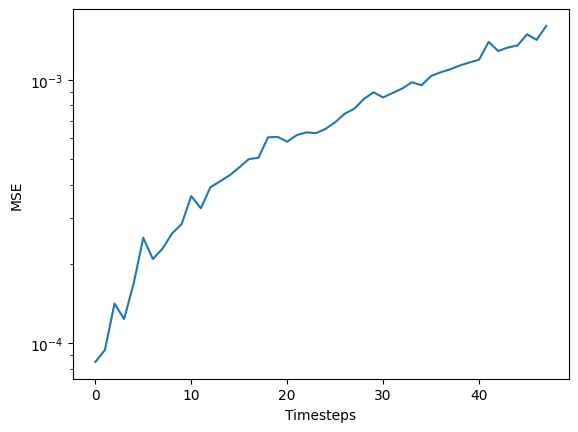

In [21]:
import matplotlib.pyplot as plt
plt.semilogy(test_cumulative_mse)
plt.xlabel('Timesteps')
plt.ylabel('MSE')